In [1]:
%load_ext kedro.extras.extensions.ipython
%reload_kedro

The kedro.extras.extensions.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.extras.extensions.ipython


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from SALib.sample import sobol as sobol_sample
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np
from rdkit import Chem
from rdkit.Chem.Descriptors import ExactMolWt
from feos.eos.estimator import *
from feos import eos
from feos import si
from feos import pcsaft
from dl4thermo.extras.utils.pcsaft import (
    create_pcsaft_parameters_from_model_predictions,
    plot_pressure_density_phase_diagram
)
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import plotly.express as px
from typing import Dict
from datetime import datetime as dt
import matplotlib.pyplot as plt

## PCP SAFT data 

In [4]:
pcp_saft_sepp = catalog.load("pcp_saft_sepp_pure_parameters")
columns = ["sigma", "m", "epsilon_k", "mu", "epsilonAB", "KAB"]

2023-02-28 17:49:19,101 - kedro.io.data_catalog - INFO - Loading data from 'pcp_saft_sepp_pure_parameters' (CSVDataSet)...


In [5]:
params_dict = create_pcsaft_parameters_from_model_predictions(
    pcp_saft_sepp, smiles_column="smiles"
)

## FeOs PC-SAFT

In [10]:
dortmund = catalog.load("dortmund_base_pure_component")
dortmund_w_density = dortmund[dortmund["DEN"].notnull()]

2023-02-28 18:29:24,024 - kedro.io.data_catalog - INFO - Loading data from 'dortmund_base_pure_component' (ParquetDataSet)...


In [11]:
name = "Pyridine"
molecule_data = dortmund[dortmund["Component"] == name]
smiles = molecule_data.iloc[0]["smiles_1"]
# smiles = "CCC(=O)O"
# molecule_data = dortmund[dortmund["smiles_1"]==smiles]

# Vapor pressure
pvap_data = molecule_data[molecule_data["DEN"].isna()]

# Density  (kg/m^3)
mol = Chem.MolFromSmiles(smiles)
mw = ExactMolWt(mol)
rho_data = molecule_data[molecule_data["DEN"].notnull()]
phase_transition_rho = rho_data.iloc[rho_data["T"].argmax()]["DEN"]
rho_data_vapor =  rho_data[rho_data["DEN"]<phase_transition_rho]
rho_data_liquid =  rho_data[rho_data["DEN"]>=phase_transition_rho]

# Equation of state cculation
parameters = params_dict[smiles]
my_eos = eos.EquationOfState.pcsaft(parameters)
liquid_states =  [
    eos.State(
        my_eos,
        temperature=row["T"]*si.KELVIN,
        pressure=row["P"]*1e3*si.PASCAL,
        density_initialization='liquid'
    )
    for _, row in rho_data_liquid.iterrows()
]
vapor_states =  [
    eos.State(
        my_eos,
        temperature=row["T"]*si.KELVIN,
        pressure=row["P"]*1e3*si.PASCAL,
        density_initialization='vapor'
    )
    for _, row in rho_data_vapor.iterrows()
]
states = liquid_states + vapor_states
phase_diagram_df = pd.DataFrame(
    [
        [
            state.temperature / si.KELVIN, 
            state.pressure() / si.PASCAL / 1e3,
            state.mass_density() / (1e3*si.GRAM)*si.METER**3
        ]
        for state in states
    ],
    columns=["T","P", "DEN"]
)
# phase_diagram = eos.PhaseDiagram.pure(
#     my_eos, min_temperature=min_temperature * si.KELVIN, npoints=100
# )
# phase_diagram_df = pd.DataFrame(phase_diagram.to_dict())

# Plot
rho_data_pred = phase_diagram_df.rename(
    columns={
        "density liquid": "DEN",
        "temperature": "T",
        "pressure": "P"
    }
)
# rho_data_pred["P"] /= 1e3 # convert to kPA
# rho_data_pred["DEN"]  =  rho_data_pred["DEN"] * mw / 1e3
rho_data_pred["Type"] = "PC-SAFT"
rho_data["Type"] = "Experiments"
# rho_data = rho_data[rho_data["DEN"]<2000]
rho_data_plot = pd.concat([rho_data, rho_data_pred])

fig = px.scatter_3d(
    rho_data_plot, 
    x="T",
    y="P", 
    z="DEN", 
    color="Type",
    opacity=0.2,
    width=600,
    height=500
)
fig.show()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /var/folders/rw/8p8g2qln5h7_f_02pz80mnl80000gn/T/ipykernel_65302/32672028.py:30 in <cell line:   │
│ 30>                                                                                              │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ '/var/folders/rw/8p8g2qln5h7_f_02pz80mnl80000gn/T/ipykernel_65302/32672028.py'                   │
│                                                                                                  │
│ /var/folders/rw/8p8g2qln5h7_f_02pz80mnl80000gn/T/ipykernel_65302/32672028.py:31 in <listcomp>    │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ '/var/folders/rw/8p8g2qln5h7_f_02pz80mnl80000gn/T/ipykernel_65302/32672028.py'                   │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
RuntimeError: Invalid state in validate: volume = NaN.

In [9]:
_ = plot_pressure_density_phase_diagram(
    {"PC-SAFT": phase_diagram_df},
    molecular_weight=mw, 
    experimental_data=molecule_data,
    # name=name
)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /var/folders/rw/8p8g2qln5h7_f_02pz80mnl80000gn/T/ipykernel_65302/175873462.py:2 in <cell line:   │
│ 1>                                                                                               │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ '/var/folders/rw/8p8g2qln5h7_f_02pz80mnl80000gn/T/ipykernel_65302/175873462.py'                  │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'phase_diagram_df' is not defined

In [7]:
def pcsaft_error(molecule_data: pd.DataFrame, smiles: str, mw: float, parameters):
    # Equation of state from parameters
    my_eos = eos.EquationOfState.pcsaft(parameters)
    
    # Vapor pressure data
    pvap_data = molecule_data[molecule_data["DEN"].isna()]
    temperatures = pvap_data["T"].to_numpy() * si.KELVIN
    pressures = pvap_data["P"].to_numpy() * 1e3 * si.PASCAL
    p_ds = DataSet.vapor_pressure(
        target=pressures,
        temperature=temperatures,
        extrapolate=True,
    )
    pvap_error = p_ds.relative_difference(my_eos)
    pvap_pred = p_ds.predict(my_eos) / (1e3 * si.PASCAL)
        
    # Density  (kg/m^3)
    rho_data = molecule_data[molecule_data["DEN"].notnull()]
    phase_transition_rho = rho_data.iloc[rho_data["T"].argmax()]["DEN"]
    # rho_data_vapor =  rho_data[rho_data["DEN"]<phase_transition_rho]
    rho_data_liquid =  rho_data[rho_data["DEN"]>phase_transition_rho]
    temperatures = rho_data_liquid["T"].to_numpy() * si.KELVIN
    pressures = rho_data_liquid["P"].to_numpy() * 1e3 * si.PASCAL
    rhos = rho_data_liquid["DEN"].to_numpy() * 1e3 * si.GRAM/si.METER**3
    rho_ds = DataSet.liquid_density(
        target=rhos,
        temperature=temperatures,
        pressure=pressures
    )
    rho_error = rho_ds.relative_difference(my_eos)
    rho_pred = rho_ds.predict(my_eos) / (1e3 * si.GRAM/si.METER**3)
    
    return {
        "vapor_pressure_prediction": pvap_pred,
        "vapor_pressure_error": pvap_error,
        "liquid_density_prediction": rho_pred,
        "liquid_density_error": rho_error,
    }
    

In [112]:
pcsaft_error(molecule_data, smiles,mw, parameters)

{
    'vapor_pressure_prediction': array([ 23.75368515, 119.84153657, 434.64339424, ..., 111.05477938,
       120.18131172, 120.9770527 ]),
    'vapor_pressure_error': array([0.15916871, 0.1889985 , 0.17471188, ..., 0.18143382, 0.18639005,
       0.19395068]),
    'liquid_density_prediction': array([508.60306209, 575.98584641, 603.83077533, 629.4215674 ,
       653.51880418, 676.73536138, 699.63677985, 672.6514419 ,
       641.34756717, 607.93949225, 570.73054038, 527.09686624,
       471.65107363, 383.58259722, 102.01125421,  84.02338448,
       359.13605606, 401.18932627, 430.15671736, 453.75641113,
       474.17089129, 508.91286913, 538.1717485 , 563.9470008 ,
       648.7885673 , 609.10236528, 563.99405874, 523.86214405,
       551.42980591, 523.95555956, 492.14281225, 453.41835964,
       648.78852987]),
    'liquid_density_error': array([-3.49820467e-02, -1.11321675e-02, -8.03197639e-03, -4.56806408e-03,
       -2.09378036e-03, -4.05664052e-04,  6.96245221e-04,  5.74369686e-03,
       -2.03442411e-03, -6.45623846e-03, -1.14498357e-02, -2.05882707e-02,
       -4.12699691e-02, -1.02470431e-01, -6.67203039e-01, -7.64301026e-01,
       -6.82463566e-02, -2.16660255e-02, -4.93484151e-03,  3.05812047e-03,
        2.62807719e-03,  8.23540310e-03,  1.54298888e-02,  2.00225381e-02,
       -2.46226525e-03, -5.17359126e-03, -1.11092547e-02, -1.95906199e-02,
       -1.22259435e-02, -1.87234465e-02, -2.92639098e-02, -4.75244629e-02,
       -1.86380020e-03])
}

## Sensitivity Analysis

In [6]:
non_associating = pcp_saft_sepp[pcp_saft_sepp["KAB"] == 0.0]
non_associating[columns].describe()

,sigma,m,epsilon_k,mu,epsilonAB,KAB
count,839.000000,839.000000,839.000000,839.000000,839.0,839.0
mean,3.692451,3.269681,284.134306,4.596324,0.0,0.0
std,0.189931,0.539915,70.159533,55.388099,0.0,0.0
min,2.636563,1.416631,139.171288,0.000000,0.0,0.0
25%,3.586253,2.918471,246.248884,0.573582,0.0,0.0
50%,3.718350,3.239285,268.247238,1.603756,0.0,0.0
75%,3.821175,3.659366,303.059485,2.841044,0.0,0.0
max,4.091064,4.634466,1203.370325,1223.000000,0.0,0.0


In [7]:
associating = pcp_saft_sepp[pcp_saft_sepp["KAB"] != 0.0]
associating_summary = associating[columns].describe()
associating_summary

,sigma,m,epsilon_k,mu,epsilonAB,KAB
count,419.000000,419.000000,419.000000,419.000000,388.000000,388.000000
mean,3.589873,2.967784,288.915059,2.397886,2412.713622,0.492235
std,0.201125,0.489185,64.181082,1.413829,482.802140,0.422432
min,2.595953,1.498256,180.734674,0.000000,1089.609431,0.005243
25%,3.480768,2.662615,240.686261,1.403015,2262.481650,0.224470
50%,3.607758,2.960514,267.808328,1.770121,2608.698003,0.376107
75%,3.730951,3.267475,330.867271,3.661264,2694.982425,0.632395
max,4.053681,4.478091,602.197967,6.620367,3662.267483,3.682140


In [8]:
def create_parameters(row: pd.Series,smiles: str):
    identifier = pcsaft.Identifier(smiles=smiles)
    psr = pcsaft.PcSaftRecord(
        m=row["m"],
        sigma=row["sigma"],
        epsilon_k=row["epsilon_k"],
        mu=row["mu"],
        kappa_ab=row["KAB"],
        epsilon_k_ab=row["epsilonAB"],
    )
    mol = Chem.MolFromSmiles(smiles)
    mw = ExactMolWt(mol)
    record = pcsaft.PureRecord(identifier, molarweight=mw, model_record=psr)
    return pcsaft.PcSaftParameters.new_pure(record)

In [9]:
def generate_local_samples(problem: dict, **kwargs):
    bounds = np.array(problem["bounds"])
    D = bounds.shape[0]
    samples = np.zeros((2*D+1, D))
    samples[0, :] = bounds[:, 1]
    for i in range(D):
        s = 2*i + 1
        error = 1e-3
        M = bounds[i,2]
        h = (error/M)**(1/3)
        for j in range(D):
            if i == j:
                lower = bounds[j, 1] - h 
                lower = lower if lower>bounds[j,0] else bounds[j,0]
                samples[s, j] = lower
                samples[s+1, j] = bounds[j, 1]+h
            else:
                samples[s, j] = bounds[j, 1]
                samples[s+1, j] = bounds[j, 1]   
    return samples

def local_analyze(problem: dict, y: np.ndarray, **kwargs):
    bounds = np.array(problem["bounds"])
    D = bounds.shape[0]
    sens = np.zeros(D)
    for i in range(D):
        delta = bounds[i,2]- bounds[i,0]
        s = 2*i + 1
        error = 1e-3
        M = bounds[i,2]
        h = (error/M)**(1/3)
        sens[i] = (y[s+1]-y[s])/h
    return sens

In [10]:
def sensitivity_analysis(
    smiles: str,
    molecule_data: pd.DataFrame,
    associating: bool,
    initial_parameters: Dict[str,float],
):
    # Define the problem
    columns = ["sigma", "m", "epsilon_k", "mu", "epsilonAB", "KAB"]
    if associating:
        problem = {
            'groups': ["Group_1", "Group_2", "Group_3", "Group_4", "Group_5", "Group_5"],
            'num_vars': 6,
            'names': columns,
            'bounds': [
                [
                    initial_parameters[param]*0.9,
                    initial_parameters[param],
                    initial_parameters[param]*1.1,

                ]
                for param in columns
            ],
            "dists": ["triang"]*len(columns),
        }
    else:
        problem = {
            'groups': ["Group_1", "Group_2", "Group_3", "Group_4", "Group_5", "Group_5"],
            'num_vars': 6,
            'names': columns,
            'bounds': [
                [
                    initial_parameters[param]*0.9,
                    initial_parameters[param],
                    initial_parameters[param]*1.1,

                ]
                for param in columns[:3]
            ] + 
            [
                [0.0, 0.0, 0.005],
                [0.0, 0.0, 0.001],
                [0.0, 0.0, 0.001],
            ]
            ,
            "dists": ["triang"]*len(columns),
        } 

    # Generate samples
    param_values = generate_local_samples(problem)
    parameters_df = pd.DataFrame(param_values, columns=columns)

    # calculate molecular weight
    mol = Chem.MolFromSmiles(smiles)
    mw = ExactMolWt(mol)

    # Evaluate samples
    pvap_errors = []
    rho_errors = []
    # for _, parameters_row in tqdm(
    #     parameters_df.iterrows(), total=len(parameters_df),desc="Evaluating"
    # ):
    for _, parameters_row in parameters_df.iterrows():
        # Generate parameters
        pcsaft_parameters = create_parameters(parameters_row, smiles)
        
        # Calculate errors
        results = pcsaft_error(molecule_data, smiles,mw, pcsaft_parameters)
        pvap_mape = np.abs(results["vapor_pressure_error"]).mean()
        rho_mape = np.abs(results["liquid_density_error"]).mean()
        pvap_errors.append(pvap_mape)
        rho_errors.append(rho_mape)

    # Analyze results
    sobol_indices = {
        target: local_analyze(
            problem, np.array(errors)
        )
        for target, errors in zip(
            ["pvap", "rho"], [pvap_errors, rho_errors]
        )
    }
    return sobol_indices

In [138]:
smiles_list = pcp_saft_sepp["Smiles"].unique()
sensitivity_indices = {}
skipped_list = []
for smiles in tqdm(smiles_list):
    # Get data
    initial_params = pcp_saft_sepp[
        pcp_saft_sepp["Smiles"]==smiles
    ].iloc[0].to_dict()
    molecule_data = dortmund[dortmund["smiles_1"] == smiles]
    
    # Only include vapor pressure and reasonable density data 
    molecule_data = molecule_data[
        (molecule_data["DEN"].isna()) | (molecule_data["DEN"]<2.5e3)
    ]
    
    # Check there is enough data
    check_1 = molecule_data[molecule_data["DEN"].isna()].shape[0] < 10
    check_2 = molecule_data[molecule_data["DEN"].notnull()].shape[0] < 10
    if check_1 or check_2:
        skipped_list.append(smiles)
        continue
    
    
    # Check if associating
    is_associating = initial_params["KAB"]>0.
    
    # Run sensitivity analysis
    try:
        indices = sensitivity_analysis(
            smiles, 
            molecule_data, 
            associating=is_associating,
            initial_parameters=initial_params,
        )
        sensitivity_indices[smiles] = indices
    except TypeError:
        skipped_list.append(smiles)
        continue

100%|███████████████████████████████████████████████████████████████████████████| 1200/1200 [05:59<00:00,  3.33it/s]


In [34]:
from dl4thermo.extras.utils.sensitivity import pcsaft_sensitivity_analysis

In [35]:
smiles_list = pcp_saft_sepp["Smiles"].unique()
smiles = smiles_list[13]
initial_params = pcp_saft_sepp[
    pcp_saft_sepp["Smiles"]==smiles
].iloc[0].to_dict()
molecule_data = dortmund[dortmund["smiles_1"] == smiles]

# Only include vapor pressure and reasonable density data 
molecule_data = molecule_data[
    (molecule_data["DEN"].isna()) | (molecule_data["DEN"]<2.5e3)
]

# Check there is enough data
check_1 = molecule_data[molecule_data["DEN"].isna()].shape[0] < 10
check_2 = molecule_data[molecule_data["DEN"].notnull()].shape[0] < 10
if check_1 or check_2:
    print("stop!!")

In [37]:
results = pcsaft_sensitivity_analysis(
    smiles,
    molecule_data=molecule_data,
    associating=False,
    initial_parameters=initial_params,
    n_samples=5
)

In [49]:
df = results["pvap"][["S1"]].T 
df["smiles"] = "hello"
pd.concat([df, df])

,sigma,m,epsilon_k,mu,epsilonAB,KAB,smiles
S1,1.0,1.0,1.0,1.0,1.0,1.0,hello
S1,1.0,1.0,1.0,1.0,1.0,1.0,hello


<BarContainer object of 6 artists>

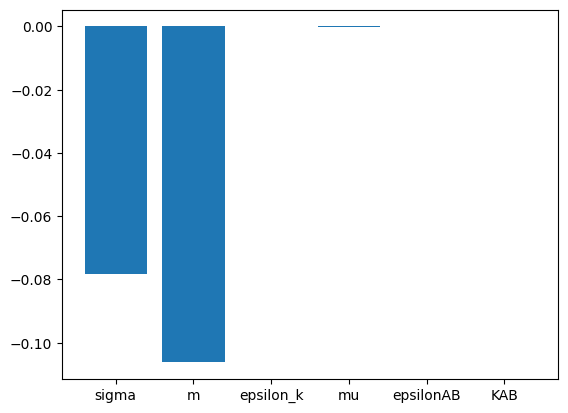

In [139]:
rho_indices = np.array([indices["rho"] for indices in sensitivity_indices.values()])
rho_indices_mean = rho_indices.mean(axis=0)
rho_indices_std = rho_indices.std(axis=0)
plt.bar(columns, rho_indices_mean)

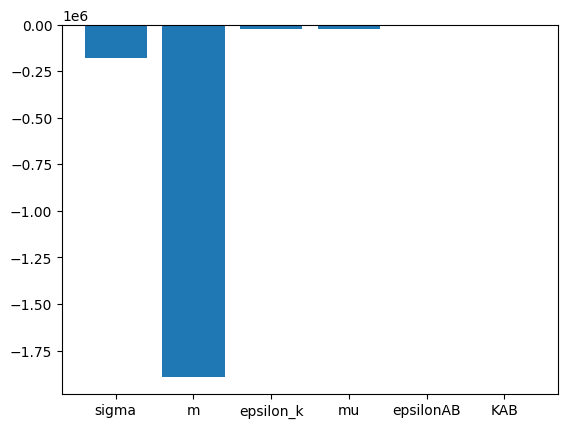

In [140]:
pvap_indices = pd.DataFrame(
    [indices["pvap"] for indices in sensitivity_indices.values()],
    columns=columns
)
pvap_indices
pvap_indices_mean = pvap_indices.mean(axis=0)
pvap_indices_std = pvap_indices.std(axis=0)
# fig, ax = plt.subplots(1)
_ = plt.bar(columns, pvap_indices_mean)

In [66]:
molecule_data = dortmund[dortmund["smiles_1"] == smiles]
print(f"Original n rows:", molecule_data.shape[0])
n_rho = molecule_data[molecule_data["DEN"]<2.5e3].shape[0]
print("Number of density measurements:", n_rho)
n_pvap = molecule_data[(molecule_data["P"].notnull()) & (molecule_data["DEN"].isna())].shape[0]
print("Number of vapor pressure measurements:", n_pvap)

Original n rows: 428
Number of density measurements: 29
Number of vapor pressure measurements: 399


## Visualization


In [33]:
pvap_df = catalog.load("pvap_sensitivity_analysis_results")
rho_df = catalog.load("rho_sensitivity_analysis_results")

2023-02-20 12:22:18,608 - kedro.io.data_catalog - INFO - Loading data from 'pvap_sensitivity_analysis_results' (CSVDataSet)...
2023-02-20 12:22:18,613 - kedro.io.data_catalog - INFO - Loading data from 'rho_sensitivity_analysis_results' (CSVDataSet)...


In [34]:
len(pvap_df)

51

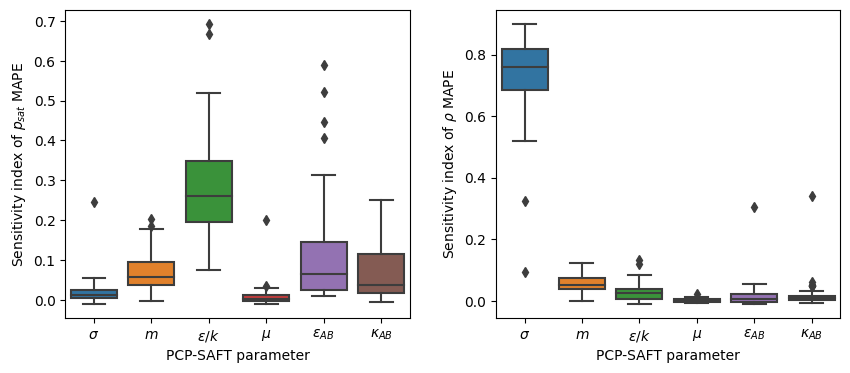

In [31]:
fig, axes = plt.subplots(2,1, figsize=(10,4))
fig.subplots_adjust(wspace=0.25)
target_display = {
    "m": r"$m$",
    "sigma": r"$\sigma$",
    "epsilon_k": r"$\epsilon/k$",
    "mu": r"$\mu$",
    "KAB": r"$\kappa_{AB}$",
    "epsilonAB": r"$\epsilon_{AB}$",
}
for i, (label, df) in enumerate(zip(
    [r"$p_{sat}$",r"$\rho$"],
    [pvap_df, rho_df]
)):
    ax = axes[i]
    df_melt = pd.melt(df.drop("smiles", axis=1))
    df_melt = df_melt.replace(target_display)
    sns.boxplot(data=df_melt, x="variable", y="value",ax=ax)
    ax.set_xlabel("PCP-SAFT parameter")
    ax.set_ylabel(f"Sensitivity index of {label} MAPE")